In [55]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappify Data

In [0]:
from PIL import Image, ImageDraw, ImageFont

In [0]:
def crappify(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    
    w, h = img.size
    q = random.randint(10, 70)
    ImageDraw.Draw(img).text((random.randint(0, w // 2), random.randint(0, h // 2)), str(q), fill=(255, 255, 255))
    
    img.save(dest, quality=q)

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
for i, item in enumerate(il.items):
    crappify(item, i)

In [28]:
!ls {path_lr} | head -n5

Abyssinian_100.jpg
Abyssinian_101.jpg
Abyssinian_102.jpg
Abyssinian_103.jpg
Abyssinian_104.jpg


For gradual resizing we can change the commented line here.

In [0]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-Train Generator

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

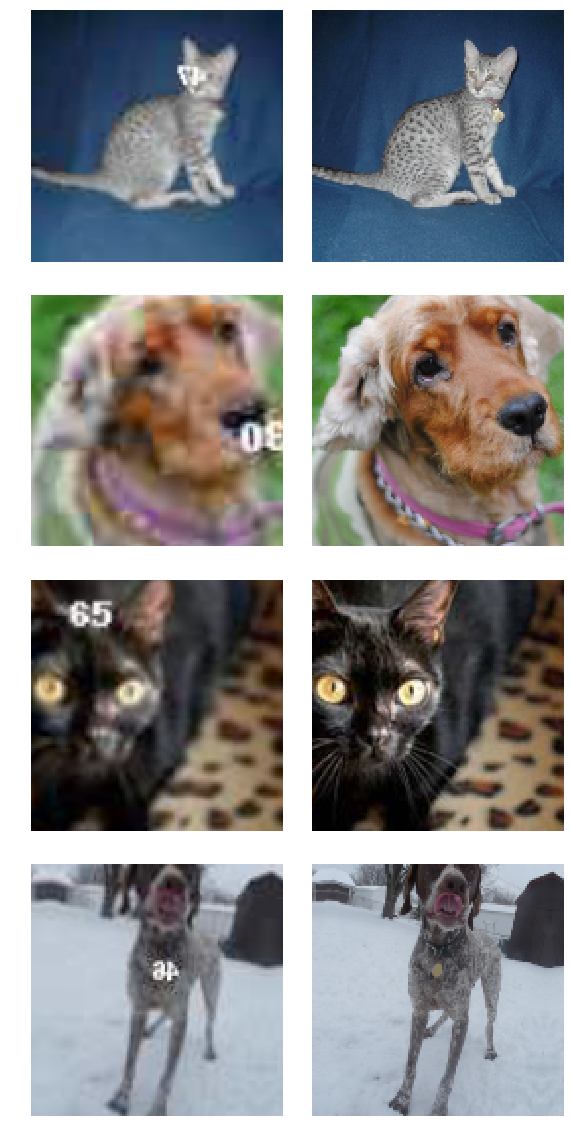

In [33]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [38]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:04, 18604531.12it/s]


In [39]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [41]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

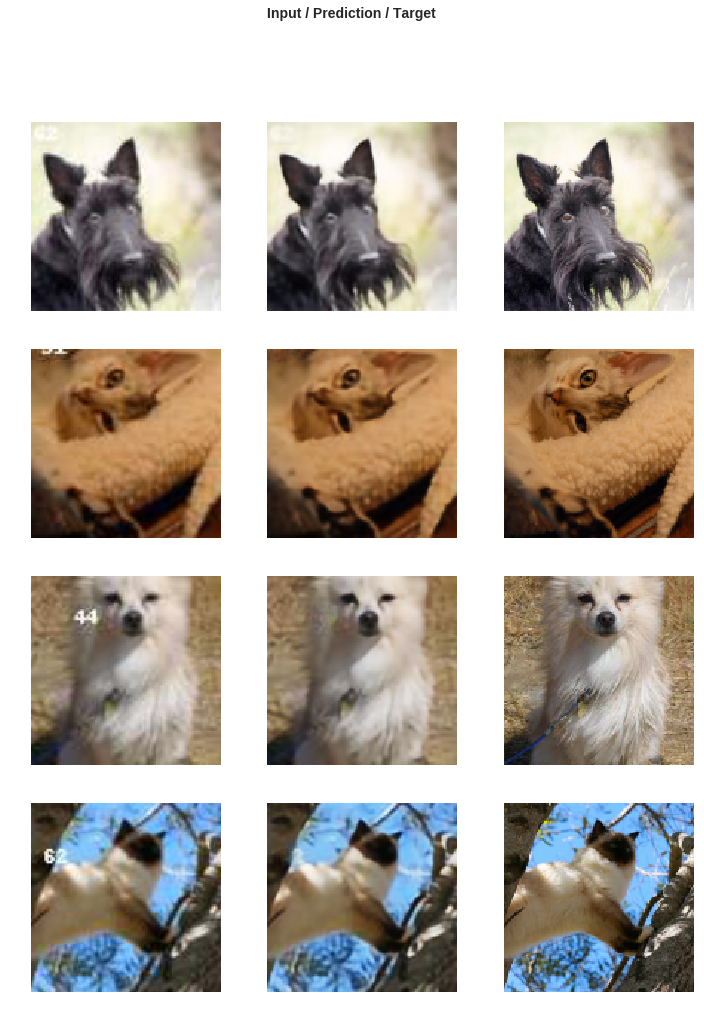

In [42]:
learn_gen.show_results(rows=4)

In [0]:
save_path = learn_gen.save('gen-pre2', return_path=True)

In [0]:
!cp {save_path} gdrive/"My Drive"/fastai-v3/

## Save generated images

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
!rm -rf {path_gen}

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

## Train discriminator (critic)

In [57]:
learn_gen=None
gc.collect()

22576

Pretrain the critic on crappy vs not crappy.

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

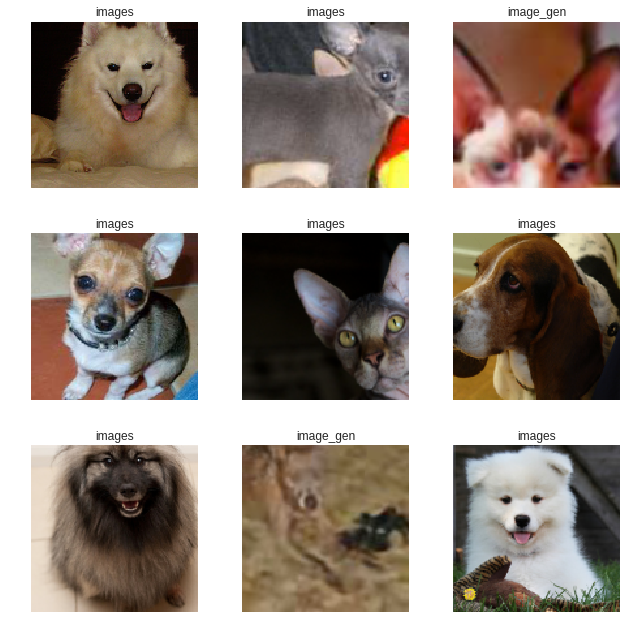

In [60]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())  # Needed for GANs and gan_critic below

In [0]:
def create_critic_learner(data, metrics):
    # Note that we don't use a ResNet here. We discuss this further in part 2, but 
    # essentially, with GANs, you need to be particularly careful that the generator
    # and the critic can't both push in the same direction and increase the weights
    # out of control. So we have to use something called spectral normalization to
    # make GANs work.
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [64]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
save_path = learn_critic.save('critic-pre2', return_path=True)

In [0]:
!cp {save_path} gdrive/"My Drive"/fastai-v3/"Lesson 7"

## GAN

In [68]:
learn_crit=None
learn_gen=None
gc.collect()

15809

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed through the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
# weights_gen is a set of weights to use, so that the pixel MSE is also considered
# Something between 50 and 200 works well in practice.
#
# Also, GANs hate momentum (hence the first beta is 0. And it doesn't really
# make sense because you keep switching between generator and critic
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

With GANs, the losses are rather meaningless, because as the generator gets better, it's harder for the discriminator, and vice versa. So the two losses roughly remain the same. So it's really hard to tell when it's done training, and the only way to find out is to look at the results.

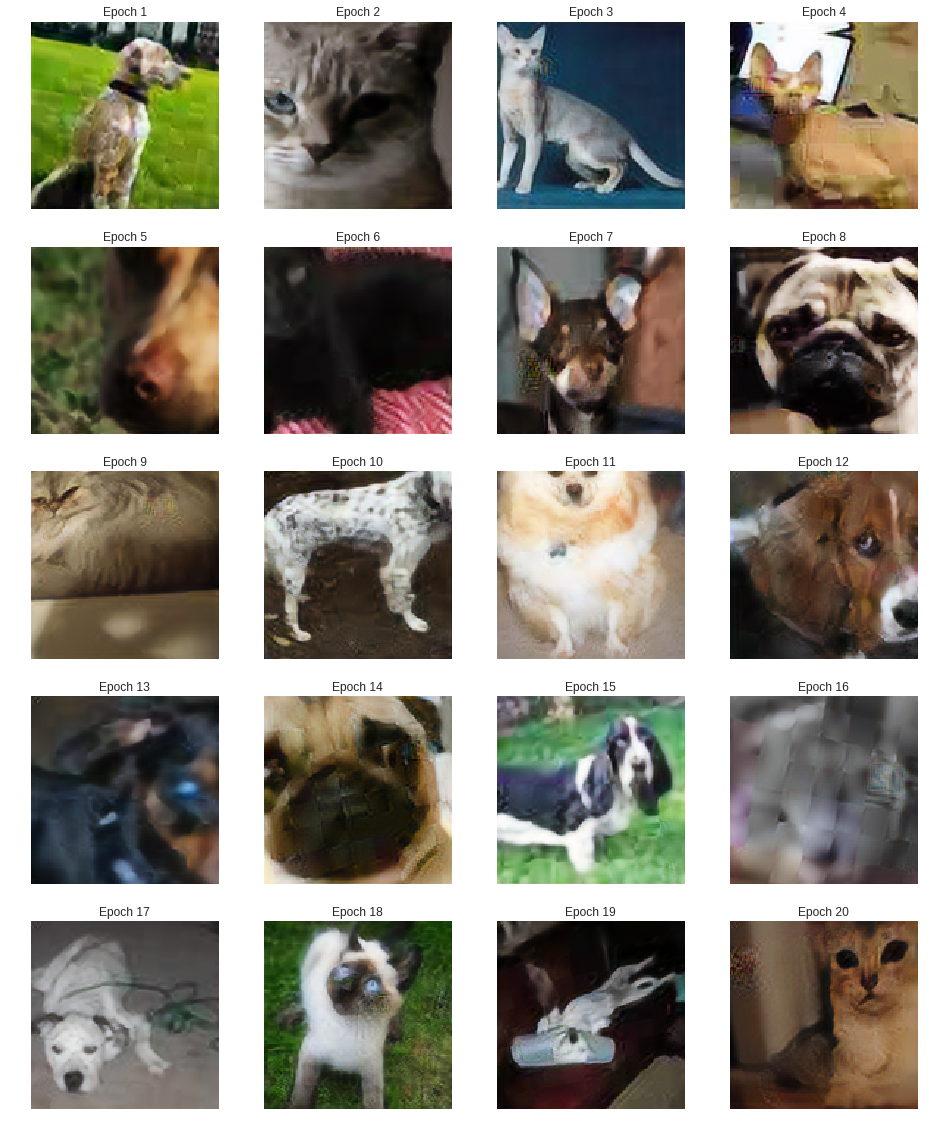

In [74]:
learn.fit(20,lr)

In [0]:
save_path = learn.save('gan-1c', return_path=True)

In [0]:
!cp {save_path} gdrive/"My Drive"/fastai-v3/"Lesson 7"

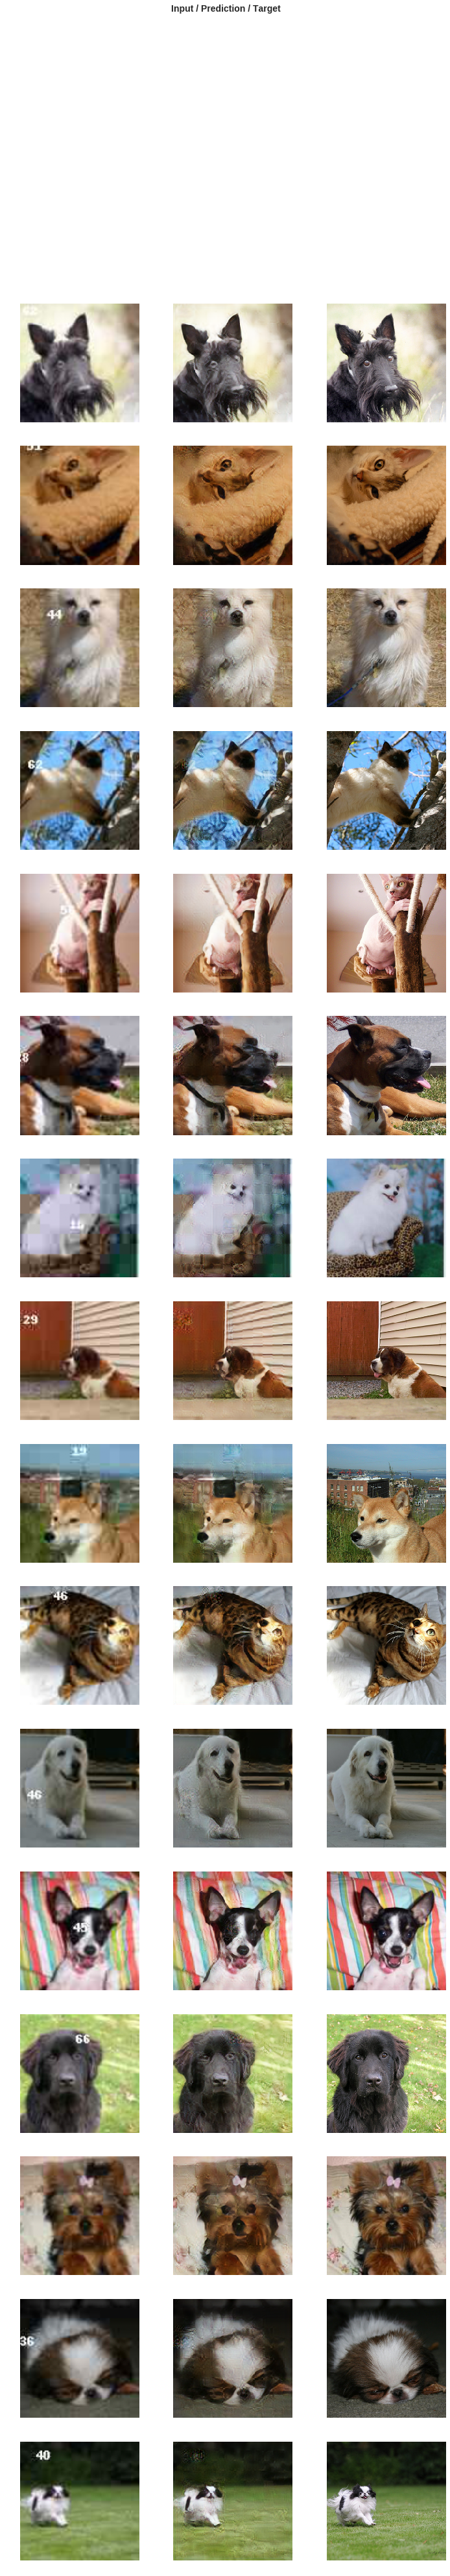

In [80]:
learn.show_results(rows=16)

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

So from below, the GAN has trouble with some things, especially things like eyeballs, because it doesn't know what an eyeball is. It doesn't know that eyeballs are particularly important.

In [0]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')